# Airbnb Analysis

In [2]:
#Magic plots after each cell
%matplotlib inline

#Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
#import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
#Read clean file and convert to CSV
data_file = pd.read_csv("Resources/CleanAirbnbData.csv")
abb_df = pd.DataFrame(data_file)
abb_df.head()

,ID,Name,Host ID,Host Name,Neighbourhood Group,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,Number of Reviews,Last Review,Reviews per Month,Calculated Host Listings Count,Availability
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [4]:
#Create dictionary for most up to date population by data by borough (2018 estimates by nyc.gov)
pop_dict = {'Brooklyn': 2582830,
            'Bronx': 1432132,
            'Manhattan': 1628701,
            'Queens': 2278906,
            'Staten Island': 476179
           }

## Who is using Airbnb in NYC?

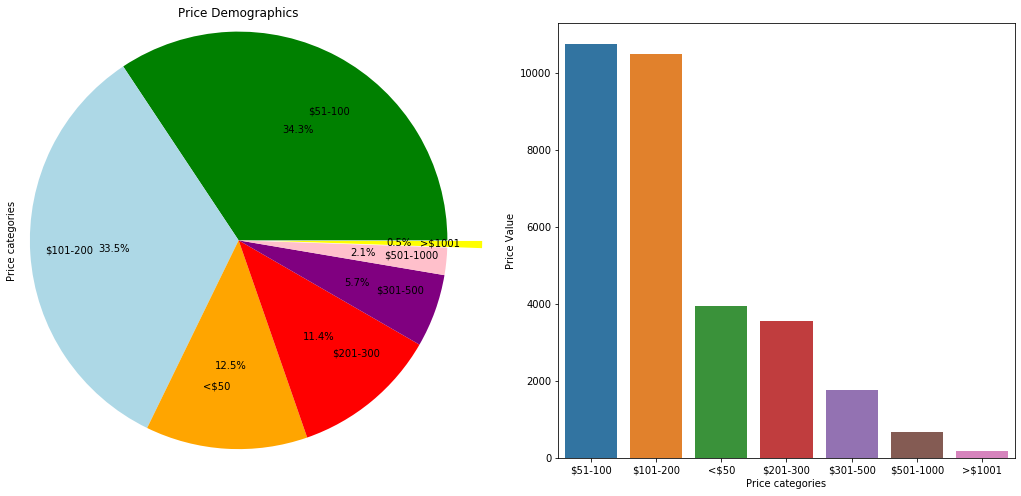

In [5]:
price_bins = [0,50,100,200,300,500,1000, max(abb_df['Price'])]
price_group_names =["<$50","$51-100","$101-200","$201-300","$301-500","$501-1000",">$1001"]
abb_df["Price categories"] = pd.cut(abb_df["Price"], price_bins, labels=price_group_names)

f,ax=plt.subplots(1,2,figsize=(18,8))
colors = ["green","lightblue","orange","red","purple","pink","yellow"]
abb_df['Price categories'].value_counts().plot.pie(explode=[0,0,0,0,0,0,0.2],colors = colors, autopct='%1.1f%%',ax=ax[0],labeldistance=0.7,radius=1.2)
ax[0].set_title('Price Demographics')

sns.countplot('Price categories',data=abb_df,ax=ax[1],order=abb_df['Price categories'].value_counts().index)
ax[1].set_ylabel('Price Value')

plt.savefig('Output/Price Demographics')
# plt.show()

In [6]:
min_p = min(abb_df['Price'])
max_p = max(abb_df['Price'])
mean_p = round(abb_df['Price'].mean(),2)
# print(f'min price:{min_p}, max price:{max_p},mean_p:{mean_p}')
price_dict={"Minimum Price":[min_p], "Maximum Price":[max_p],"Mean Price":[mean_p]}
price_df = pd.DataFrame(price_dict)
price_df  

,Minimum Price,Maximum Price,Mean Price
0,0,10000,162.05


In [7]:
# List Demographics
list_bins = [0,1,5, 10, 20,30,50,100,200,max(abb_df['Calculated Host Listings Count'])]
list_group_names =['1_list','2-5','6-10','11-20','21-30','31-50','51-100','101-200','>201']
abb_df["List Categories"] = pd.cut(abb_df["Calculated Host Listings Count"], list_bins, labels=list_group_names)
List_Demographics = pd.DataFrame(abb_df["List Categories"].value_counts())
List_Demographics.reset_index()
List_Demographics["Percentage of listing"]= round(List_Demographics["List Categories"]/ List_Demographics["List Categories"].sum() *100,2)

List_Demographics.rank(axis=0, numeric_only=False)
List_Demographics


,List Categories,Percentage of listing
1_list,17393,55.46
2-5,9370,29.88
6-10,1731,5.52
11-20,712,2.27
>201,559,1.78
31-50,556,1.77
51-100,526,1.68
21-30,302,0.96
101-200,213,0.68


In [8]:
lists = ['1_list','2-5','6-10','11-20','21-30','31-50','51-100','101-200','>201'
pie_x = List_Demographics["List Categories"]
colors = ["green","lightblue","orange","red","purple","pink","yellowgreen","lightskyblue","yellow"]
plt.pie(pie_x, labels=lists,colors=colors,autopct="%1.1f%%",radius=3)

SyntaxError: invalid syntax (<ipython-input-8-0e344f83c815>, line 2)

## How is Airbnb used in the different boroughs? 

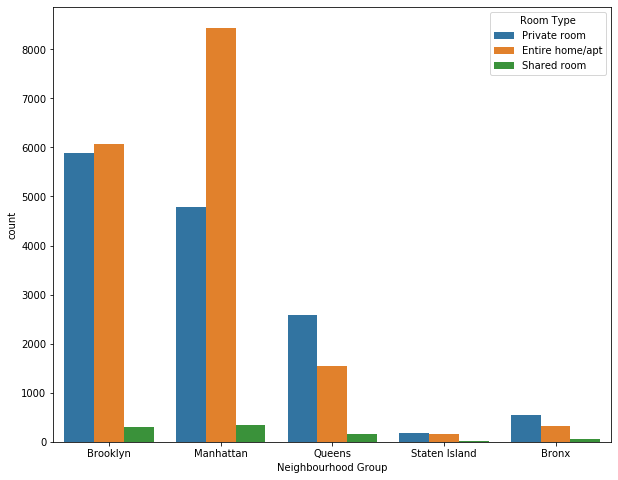

In [9]:
plt.figure(figsize=(10,8))
sns.countplot(x="Neighbourhood Group", hue="Room Type", data=abb_df)
plt.show()

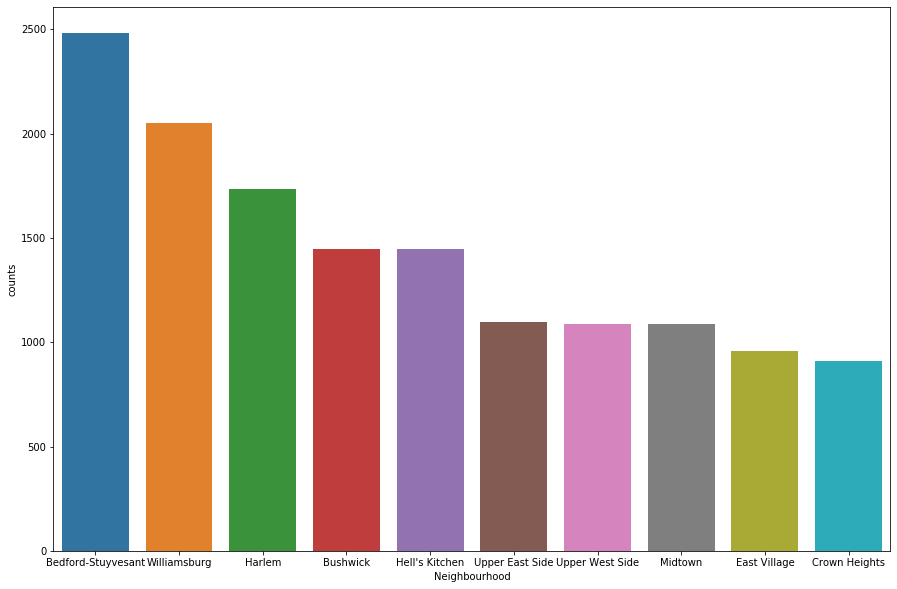

In [10]:
popneighbourhood = abb_df['Neighbourhood'].value_counts().head(10).reset_index()
popneighbourhood.columns = ['Neighbourhood','counts']

plt.figure(figsize=(15,10))
sns.barplot(x='Neighbourhood', y='counts', data=popneighbourhood)
plt.show()

## How do house building projects affect their Airbnb use? 

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [12]:
airb_file = 'Resources/CleanAirbnbData.csv'
nyhs_file = 'Resources/Housing_New_York_Units_by_Building.csv'


df_airb = pd.read_csv(airb_file)
df_nyhs = pd.read_csv(nyhs_file)
df_nyhs_cl = df_nyhs[df_nyhs['Census Tract'].notnull()]

In [13]:
grp_nyhs_bor = df_nyhs_cl.groupby(['Borough'])
grp_airb_bor = df_airb.groupby(['Neighbourhood Group'])

df_nyhs_bybor = pd.DataFrame({'Building Count':grp_nyhs_bor['Borough'].count(),
                             'BCount Pct': (grp_nyhs_bor['Borough'].count()/df_nyhs_cl['Borough'].count()) * 100,
                              'Unit Count': grp_nyhs_bor['All Counted Units'].sum(),
                              'UCount Pct' : (grp_nyhs_bor['All Counted Units'].sum()/df_nyhs_cl['All Counted Units'].sum()) * 100,
                              'Counted Rental Units': grp_nyhs_bor['Counted Rental Units'].sum(),
                              'CRUnits Pct' : (grp_nyhs_bor['Counted Rental Units'].sum()/df_nyhs_cl['Counted Rental Units'].sum()) * 100,
                               'Home Own Units': grp_nyhs_bor['Counted Homeownership Units'].sum(),
                              'HOUnits Pct' : (grp_nyhs_bor['Counted Homeownership Units'].sum()/df_nyhs_cl['Counted Homeownership Units'].sum()) * 100})
                                


df_airb_bybor = pd.DataFrame({'Listing Count':grp_airb_bor['Neighbourhood Group'].count(),
                             'LCount Pct' : (grp_airb_bor['Neighbourhood Group'].count()/df_airb['Neighbourhood Group'].count()) * 100 })


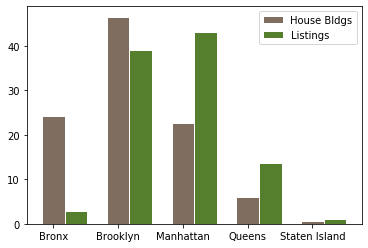

In [14]:
#Show Correlation of House Buildings and Number of AirBnB Listings
import numpy as np
fig, ax =  plt.subplots()

ind = np.arange(5)    # the x locations for the groups
width = 0.35         # the width of the bars

p1 = ax.bar(ind, df_nyhs_bybor['BCount Pct'], width, color='#7f6d5f', edgecolor='white', label='House Bldg Pct')
p2 = ax.bar(ind + width, df_airb_bybor['LCount Pct'],width, color='#557f2d', edgecolor='white', label='Listing Pct')

#ax.yaxis.set_units(inch)
ax.autoscale_view()
ax.legend((p1[0], p2[0]), ('House Bldgs', 'Listings'))

ax.set_xticklabels((0,'Bronx','Brooklyn','Manhattan','Queens','Staten Island'))

plt.show()

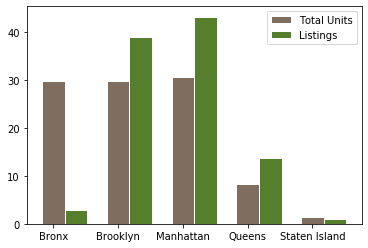

In [15]:
#Show Correlation of Total Units and Number of AirBnB Listings
import numpy as np
fig, ax =  plt.subplots()

ind = np.arange(5)    # the x locations for the groups
width = 0.35         # the width of the bars

p1 = ax.bar(ind, df_nyhs_bybor['UCount Pct'], width, color='#7f6d5f', edgecolor='white', label='House Bldg Pct')
p2 = ax.bar(ind + width, df_airb_bybor['LCount Pct'],width, color='#557f2d', edgecolor='white', label='Listing Pct')

#ax.yaxis.set_units(inch)
ax.autoscale_view()
ax.legend((p1[0], p2[0]), ('Total Units', 'Listings'))

ax.set_xticklabels((0,'Bronx','Brooklyn','Manhattan','Queens','Staten Island'))

plt.show()

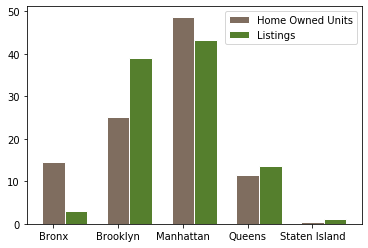

In [16]:
#Show Correlation of Home Owned Units and Number of AirBnB Listings
import numpy as np
fig, ax =  plt.subplots()

ind = np.arange(5)    # the x locations for the groups
width = 0.35         # the width of the bars

p1 = ax.bar(ind, df_nyhs_bybor['HOUnits Pct'], width, color='#7f6d5f', edgecolor='white', label='Home Owned Pct')
p2 = ax.bar(ind + width, df_airb_bybor['LCount Pct'],width, color='#557f2d', edgecolor='white', label='Listing Pct')

#ax.yaxis.set_units(inch)
ax.autoscale_view()
ax.legend((p1[0], p2[0]), ('Home Owned Units', 'Listings'))

ax.set_xticklabels((0,'Bronx','Brooklyn','Manhattan','Queens','Staten Island'))

plt.show()

## Does crime have an impact on the Airbnb's use in different boroughs?

In [17]:
#Extract arrest data and convert data frame
arrest_df = pd.read_csv("Resources/NYPD_Arrest_Data__Year_to_Date_.csv")
arrest_df.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,203078287,09/30/2019,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1600500,F,M,9,0,25-44,M,BLACK HISPANIC,990563,203120,40.724200,-73.977226
1,203072424,09/30/2019,268.0,CRIMINAL MIS 2 & 3,121.0,CRIMINAL MISCHIEF & RELATED OF,PL 1450502,F,Q,113,0,18-24,M,BLACK,1040611,190715,40.689974,-73.796769
2,203061215,09/30/2019,905.0,"INTOXICATED DRIVING,ALCOHOL",347.0,INTOXICATED & IMPAIRED DRIVING,VTL11920U3,M,S,122,0,18-24,M,WHITE,962989,160112,40.606129,-74.076570
3,203061218,09/30/2019,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1601502,F,S,120,0,25-44,M,WHITE HISPANIC,962822,174282,40.645023,-74.077217
4,203063729,09/30/2019,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1601001,F,Q,106,0,18-24,M,ASIAN / PACIFIC ISLANDER,1035521,188624,40.684266,-73.815138


In [18]:
#Create a new column with borough name
arrest_df['Borough'] = arrest_df['ARREST_BORO']
borough_name = {'M':'Manhattan', 'Q':'Queens', 'S':'Staten Island', 'B':'Bronx', 'K':'Brooklyn'}
arrest_df['Borough'] = arrest_df['Borough'].replace(borough_name)

In [19]:
#Create a new datafrmae compiling the totals for arrest per borough 
total_arrest_df = pd.DataFrame(arrest_df['Borough'].value_counts())

#Clean up column names and show
total_arrest_df = total_arrest_df.reset_index()
total_arrest_df = total_arrest_df.rename(columns={'index':'Borough','Borough':'Total Arrests'})

In [20]:
#Add population column and arrests per 1000 column
total_arrest_df['Population'] = [pop_dict['Brooklyn'], 
                                pop_dict['Manhattan'], 
                                pop_dict['Bronx'], 
                                pop_dict['Queens'],
                                pop_dict['Staten Island']]
total_arrest_df

,Borough,Total Arrests,Population
0,Brooklyn,45842,2582830
1,Manhattan,41793,1628701
2,Bronx,38309,1432132
3,Queens,34864,2278906
4,Staten Island,7157,476179


In [21]:
#Create dataframe for total listings by borough
total_listing_df = pd.DataFrame(abb_df['Neighbourhood Group'].value_counts())

#Clean up df
total_listing_df = total_listing_df.reset_index()
total_listing_df = total_listing_df.rename(columns={'index':'Borough', 'Neighbourhood Group':'Total Listings'})
total_listing_df

,Borough,Total Listings
0,Manhattan,13559
1,Brooklyn,12260
2,Queens,4298
3,Bronx,914
4,Staten Island,331


In [22]:
#Merge with arrest df

comparison_df = total_listing_df.merge(total_arrest_df, how='outer', on='Borough')
comparison_df['Arrests per 1000'] = comparison_df['Total Arrests'] / comparison_df['Population'] * 1000
comparison_df['Listings per 1000'] = comparison_df['Total Listings'] / comparison_df['Population'] * 1000
comparison_df = comparison_df.set_index('Borough')
comparison_df

,Total Listings,Total Arrests,Population,Arrests per 1000,Listings per 1000
Borough,,,,,
Manhattan,13559,41793,1628701,25.660327,8.325039
Brooklyn,12260,45842,2582830,17.748748,4.746731
Queens,4298,34864,2278906,15.298569,1.885993
Bronx,914,38309,1432132,26.749629,0.638209
Staten Island,331,7157,476179,15.030062,0.695117


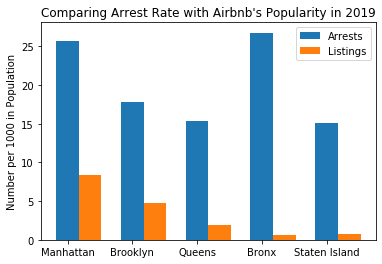

In [23]:
#Plot arrest rate vs airnbnb listing rate
fig, ax = plt.subplots()

ind = np.arange(5)
width = 0.35

ax.bar(ind, comparison_df['Arrests per 1000'], width, label='Arrests')
ax.bar(ind+width, comparison_df['Listings per 1000'], width, label='Listings')

ax.set_xticklabels((0, 'Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'))

plt.title("Comparing Arrest Rate with Airbnb's Popularity in 2019")
plt.ylabel('Number per 1000 in Population')
plt.legend(loc='upper right')

plt.savefig('Output/ArrestsandAirbnb')

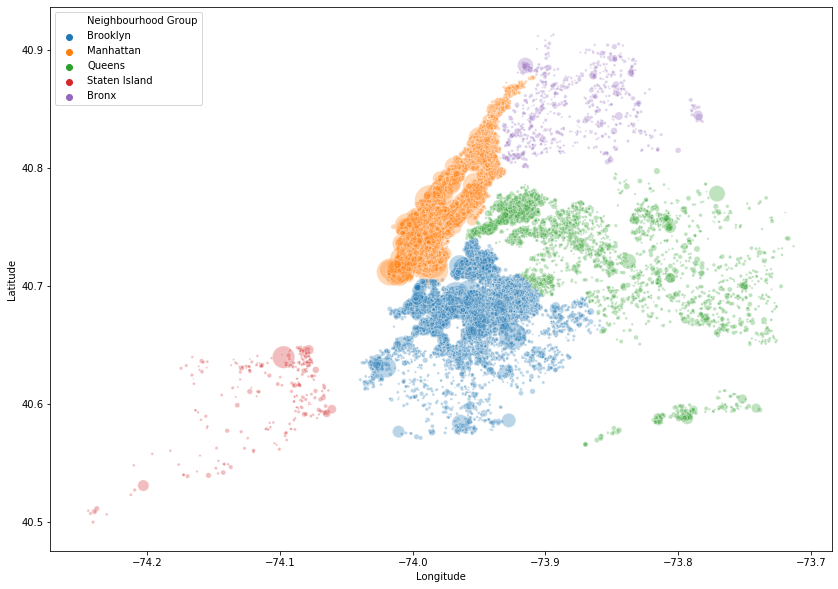

In [77]:
plt.figure(figsize=(14,10))
sns.scatterplot(abb_df['Longitude'],abb_df['Latitude'], hue=abb_df['Neighbourhood Group'], 
                s=abb_df['Price']/10, alpha=0.3)

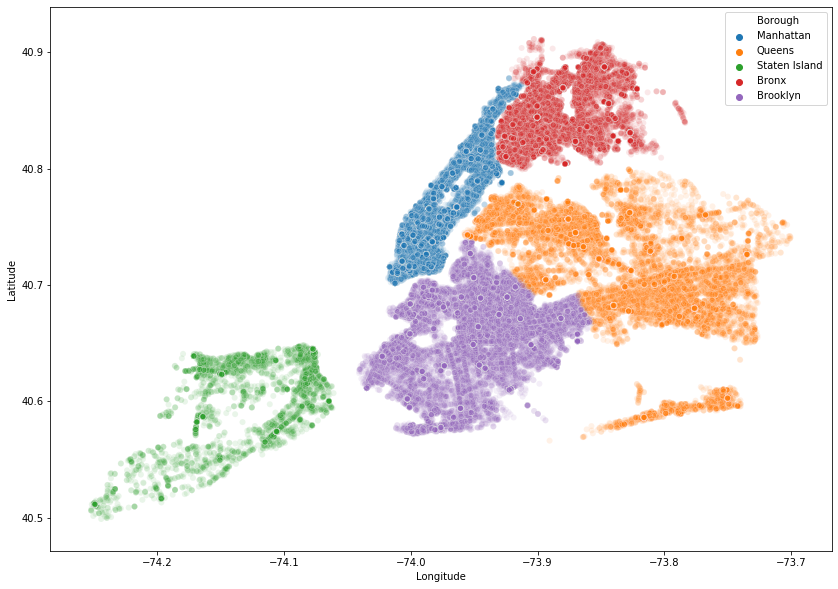

In [70]:
plt.figure(figsize=(14,10))
sns.scatterplot(arrest_df['Longitude'],arrest_df['Latitude'], hue=arrest_df['Borough'], alpha=0.1)
plt.show()

## Is there a relation between hashtagged twitter data and the popularity of Airbnb in those areas? 

In [24]:
#Read all twitter data files
manhattan_df = pd.read_csv("Twitter Data/manhattan.csv", header=None)
brooklyn_df = pd.read_csv("Twitter Data/brooklyn.csv", header=None)
queens_df = pd.read_csv("Twitter Data/queens.csv", header=None)
bronx_df = pd.read_csv("Twitter Data/bronx.csv", header=None)
statenisland_df = pd.read_csv("Twitter Data/statenisland.csv", header=None)

In [25]:
#Create dataframe with total hashtagged tweets per borough
brooklyntweets = len(brooklyn_df)
manhattantweets = len(manhattan_df)
bronxtweets = len(bronx_df)
queenstweets = len(queens_df)
statenislandtweets = len(statenisland_df)

hashtag_df = pd.DataFrame({
    "Borough":["Brooklyn", "Manhattan", "Bronx", "Queens", "Staten Island"],
    "Number of Tweets":[brooklyntweets, manhattantweets, bronxtweets, queenstweets, statenislandtweets]
})

In [26]:
#Merge with combined df
comparison2_df = comparison_df.merge(hashtag_df, how='outer', on='Borough')
comparison2_df['Tweets per 1000'] = comparison2_df['Number of Tweets'] / comparison2_df['Population'] * 1000
comparison2_df

,Borough,Total Listings,Total Arrests,Population,Arrests per 1000,Listings per 1000,Number of Tweets,Tweets per 1000
0,Manhattan,13559,41793,1628701,25.660327,8.325039,7016,4.307727
1,Brooklyn,12260,45842,2582830,17.748748,4.746731,8859,3.429959
2,Queens,4298,34864,2278906,15.298569,1.885993,3366,1.477025
3,Bronx,914,38309,1432132,26.749629,0.638209,2538,1.772183
4,Staten Island,331,7157,476179,15.030062,0.695117,1224,2.570462


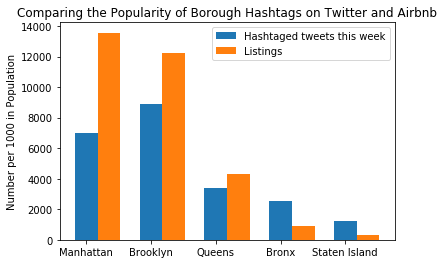

In [28]:
#Plot hashtag rate vs airnbnb listing rate
fig, ax = plt.subplots()

ind = np.arange(5)
width = 0.35

ax.bar(ind, comparison2_df['Number of Tweets'], width, label='Hashtaged tweets this week')
ax.bar(ind+width, comparison2_df['Total Listings'], width, label='Listings')

ax.set_xticklabels((0, 'Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'))

plt.title("Comparing the Popularity of Borough Hashtags on Twitter and Airbnb")
plt.ylabel('Number per 1000 in Population')
plt.legend(loc='upper right')

plt.savefig('Output/HashtagsandAirbnb')